In [58]:
pip install nilearn

Note: you may need to restart the kernel to use updated packages.


In [59]:
import pandas as pd
import numpy as np
from nilearn.glm.first_level import make_first_level_design_matrix
import matplotlib.pyplot as plt
from nilearn.plotting import plot_design_matrix
from nilearn.glm.first_level import FirstLevelModel

## DESIGN MATRIX FOR ONE RUN

In [47]:
TR = 3.0  # Repetition time in seconds
n_scans = 105  # Number of scans in each functional run
frame_times = np.arange(n_scans) * TR  # Array of frame times in seconds

# Define events with onsets, durations, and trial types based on the experiment blocks
# Each block is 33 seconds long and repeats in a specific sequence.
events = pd.DataFrame({
    'onset': [0, 33, 66, 99, 132, 165, 198, 231, 264, 297],  # Onsets in seconds for each condition block
    'duration': [33] * 10,  # Duration for each block (33 seconds each for a total of 5min24sec = 324sec )
    'trial_type': ['pure_tone', 'positive', 'pure_tone', 'negative', 'pure_tone',
                   'positive', 'pure_tone', 'negative', 'pure_tone', 'positive']
})


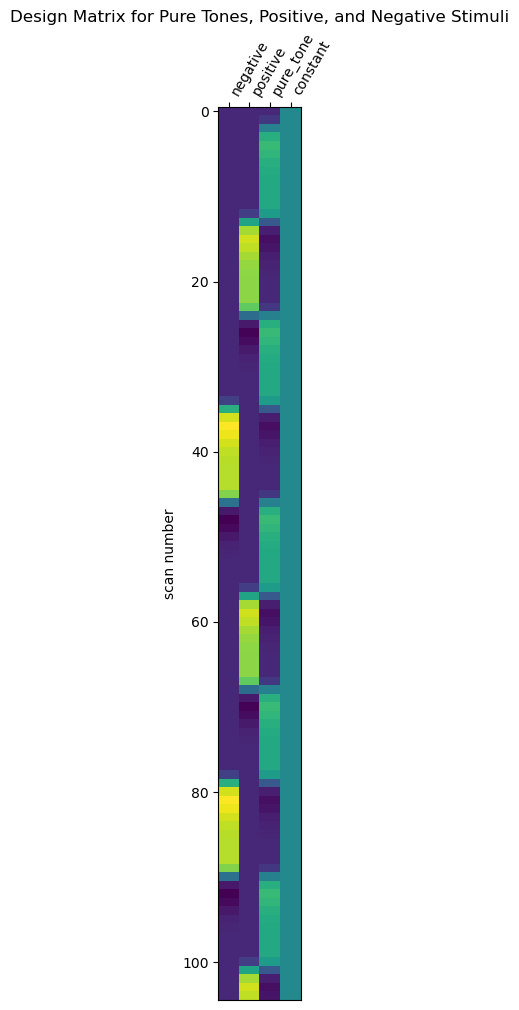

In [48]:
# Create design matrix using a specified HRF model (SPM)
design_matrix = make_first_level_design_matrix(
    frame_times=frame_times,
    events=events,
    hrf_model='spm',
    drift_model= None,
)

# Plot the design matrix
plot_design_matrix(design_matrix)
plt.title("Design Matrix for Pure Tones, Positive, and Negative Stimuli")
plt.show()

### DESIGN MATRIX FOR 3 RUNS CONCATENATED 

Total Frame Times: 315
    onset  duration trial_type
0       0        33  pure_tone
1      33        33   positive
2      66        33  pure_tone
3      99        33   negative
4     132        33  pure_tone
5     165        33   positive
6     198        33  pure_tone
7     231        33   negative
8     264        33  pure_tone
9     297        33   positive
10    324        33  pure_tone
11    357        33   positive
12    390        33  pure_tone
13    423        33   negative
14    456        33  pure_tone
15    489        33   positive
16    522        33  pure_tone
17    555        33   negative
18    588        33  pure_tone
19    621        33   positive
20    648        33  pure_tone
21    681        33   positive
22    714        33  pure_tone
23    747        33   negative
24    780        33  pure_tone
25    813        33   positive
26    846        33  pure_tone
27    879        33   negative
28    912        33  pure_tone
29    945        33   positive


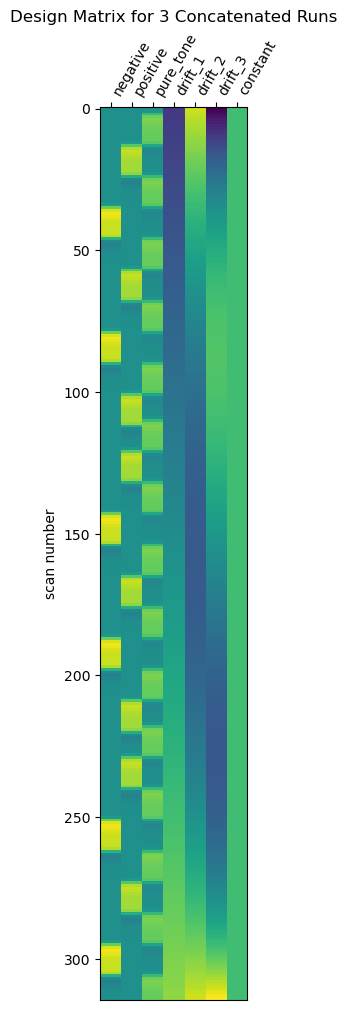

In [60]:
# Parameters
TR = 3.0  # Repetition time in seconds
n_scans_per_run = 105  # Number of scans in each run
n_runs = 3  # Number of runs
total_scans = n_scans_per_run * n_runs  # Total number of scans across all runs

# Create frame times across all runs
frame_times = np.arange(total_scans) * TR  # Now covers all 315 scans

# Define the events for a single run
single_run_events = pd.DataFrame({
    'onset': [0, 33, 66, 99, 132, 165, 198, 231, 264, 297],  # Onset times in seconds for each condition block
    'duration': [33] * 10,  # Duration of each block (33 seconds each)
    'trial_type': ['pure_tone', 'positive', 'pure_tone', 'negative', 'pure_tone',
                   'positive', 'pure_tone', 'negative', 'pure_tone', 'positive']
})

# Concatenate events for all runs, adjusting onset times for each
all_events = pd.concat([
    single_run_events.assign(onset=single_run_events['onset'] + run * 324)  # Shift onset by 324s per run
    for run in range(n_runs)
], ignore_index=True)

# Confirm all_events and frame_times span the entire concatenated run length
print(f"Total Frame Times: {len(frame_times)}")  # Should be 315
print(all_events)

# Create design matrix using specified HRF model
design_matrix_conc = make_first_level_design_matrix(
    frame_times=frame_times,
    events=all_events,
    hrf_model='spm',
    drift_model='polynomial',  # a choisir !
    drift_order=3 
)

# Plot the design matrix
plot_design_matrix(design_matrix_conc)
plt.title("Design Matrix for 3 Concatenated Runs")
plt.show()

## DRIFT MODEL SELECTION 
A **polynomial drift model** captures slow changes in the scanner signal without affecting task signals, which is useful for longer scans, especially with a TR of around 3 seconds that allows us to model these low-frequency drifts well. **Motion correction regressors** remove artifacts from any head movement, keeping task-related brain activity clear. PAS ENCORE MIS LES MOTIONS REGRESSORS 

## INITIALIZE GLM 

In [52]:
from nilearn.glm.first_level import FirstLevelModel
drift_model = 'polynomial'  # Model to correct for slow signal drifts
high_pass = 0.01  # High-pass filter cutoff, in Hz

# Initialize the GLM model with drift correction and AR(1) noise model
fmri_glm = FirstLevelModel(
    t_r=TR,
    noise_model='ar1',
    standardize=False,
    hrf_model='spm',
    drift_model=drift_model,
    high_pass=high_pass
)

In [53]:
#extract the preprocessed func file 
import nibabel as nib
func_img = nib.load("/Users/poseidon/Desktop/concatenated_smoothed.nii.gz")

# Fit the GLM to the functional image and design matrix
fmri_glm = fmri_glm.fit(func_img, design_matrices=design_matrix_conc)

## BETA AND STATISTICAL MAP OF THE REGRESSOR - A faire 

In [ ]:
from nilearn import plotting

# Retrieve beta maps and statistical maps for each regressor
regressor_names = design_matrix_conc.columns  # List of regressors from design matrix

for regressor in regressor_names:
    # Get the contrast for the regressor, which includes both beta and statistical maps
    contrast = fmri_glm.compute_contrast(regressor, output_type='all')
    
    # Display beta map
    print(f"Displaying beta map for: {regressor}")
    plotting.plot_stat_map(
        contrast['effect_size'], title=f"Beta Map for {regressor}", colorbar=True
    )
    
    # Display statistical map (t-stat map)
    print(f"Displaying statistical map for: {regressor}")
    plotting.plot_stat_map(
        contrast['stat'], title=f"Statistical Map for {regressor}", colorbar=True
    )
